## Text Emotion Annotator

In [5]:
%run Configure.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 reddit.txt
[i] Importing Modules...
[+] Using Keras version 2.3.1
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7748. 12978. 12732.  3481.   892.]
[+] Validation:
 [1895. 3319. 3206.  820.  217.]
[i] Loading GloVe from: reddit.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [6]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [7]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [8]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [9]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [10]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [11]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [12]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [13]:
!rm -r logs

rm: logs: No such file or directory


In [14]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [15]:
model.summary()
model.save('TextEmotionAnnotation.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
____________________________________________________________________________________________

In [35]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
# model = keras.models.load_model("checkpoint-0.91.h5")

In [22]:
import pandas

Time to train!!

In [16]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
# pandas.DataFrame(model_log.history).to_csv("history-emotion.csv")

Training Progress:

Train on 37831 samples, validate on 9457 samples
Epoch 1/20
37831/37831 [==============================] - 257s 7ms/step - loss: 1.2602 - acc: 0.4387 - val_loss: 1.1038 - val_acc: 0.5370
Epoch 2/20
37831/37831 [==============================] - 347s 9ms/step - loss: 1.0722 - acc: 0.5531 - val_loss: 1.0074 - val_acc: 0.5822
Epoch 3/20
37831/37831 [==============================] - 335s 9ms/step - loss: 1.0070 - acc: 0.5830 - val_loss: 0.9684 - val_acc: 0.5975
Epoch 4/20
37831/37831 [==============================] - 302s 8ms/step - loss: 0.9741 - acc: 0.5999 - val_loss: 0.9454 - val_acc: 0.6091
Epoch 5/20
37831/37831 [==============================] - 297s 8ms/step - loss: 0.9548 - acc: 0.6078 - val_loss: 0.9354 - val_acc: 0.6144
Epoch 6/20
37831/37831 [==============================] - 311s 8ms/step - loss: 0.9444 - acc: 0.6127 - val_loss: 0.9252 - val_acc: 0.6201
Epoch 7/20
37831/37831 [==============================] - 313s 8ms/step - loss: 0.9353 - acc: 0.6189 - 

NameError: name 'pandas' is not defined

In [19]:
import pandas

In [23]:
pandas.DataFrame(model_log.history).to_csv("history-emotion.csv")

## Model Testing and Inference

In [54]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "joy", "sadness", "disgust","anger"]

In [55]:
! ls

Configure.ipynb            history-emotion.csv
ExtraFunctions.ipynb       model.h5
TextEmotionAnnotation.h5   model.json
TextEmotionAnnotator.ipynb reddit.txt
best_weights.h5            tokenizer.pickle
data.csv                   train.json


In [56]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [57]:
# model_test = load_model('checkpoint-0.866.h5')
# from keras.models import load_model
# model_test = load_model('best_weights.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = loaded_model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [58]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.46      0.41      0.43      1895
         joy       0.68      0.66      0.67      3319
     sadness       0.61      0.71      0.66      3206
     disgust       0.88      0.65      0.75       820
       anger       0.96      0.71      0.82       217

    accuracy                           0.63      9457
   macro avg       0.72      0.63      0.66      9457
weighted avg       0.63      0.63      0.63      9457



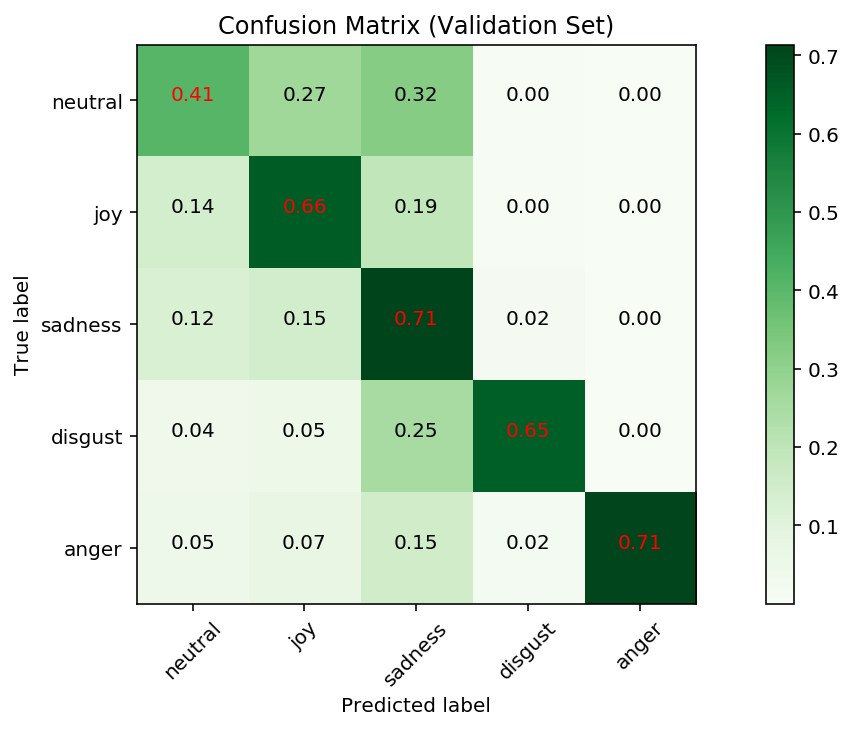

In [63]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [60]:
text = ["It feels too close for comfort for me, but aside from yall, I'm alone in my concerns.  \n\nMy friends were on the previous Grand Princess cruise.  The county dept of health &amp; Princess cruises contacted them by phone but since it was more than 14 days ago, they're not candidates for further follow up.    My Ma flew into Ontario airport the same day the Wuhan/March AFB evacuees were being sent home after their 14 days, the same day there was unclear news of one of them testing positive &amp; being released from a hospital in San Diego &amp; at a point where there was word from China that it was airborne.   \n\nIt is my opinion we'll be hearing Spanish Flu (even) more over the coming weeks-I don't think there's anything else this can be compared to for bad luck, virulence &amp; bad decisions.  It's undecided whether the Spanish Flu came from America or China.  It's unclear how it got it's name, but I think it might be because Spain was one of the only countries that wasn't censoring the news &amp; instead was reporting it in gory detail.  The King of Spain had it &amp; so did Woodrow Wilson.   \u201cThat men do not learn very much from the lessons of history is  the most important of all the lessons that history has to teach.\u201d     -Huxley\n\n[https://www.nzherald.co.nz/world/news/article.cfm?c\\_id=2&amp;objectid=12307276](https://www.nzherald.co.nz/world/news/article.cfm?c_id=2&amp;objectid=12307276)\n\n[https://en.wikipedia.org/wiki/Spanish\\_flu](https://en.wikipedia.org/wiki/Spanish_flu)\n\n[https://www.history.com/news/why-was-it-called-the-spanish-flu](https://www.history.com/news/why-was-it-called-the-spanish-flu)\n\n[https://www.goodreads.com/quotes/16293-that-men-do-not-learn-very-much-from-the-lessons](https://www.goodreads.com/quotes/16293-that-men-do-not-learn-very-much-from-the-lessons)",
        "No problem. The other trick CCP usually pulls is to take articles/internet posts &amp; replies from western media/websites (that are blocked by GFW) and show PART of them on Chinese media/internet in a way that completely misrepresent and/or twist its original meaning so that Chinese people (that are locked inside GFW) get mad at the west and think USA is not just bad but want to dominate/overpower China (CCP intentionally blend themselves into the concept \"China\") and that everything is \"the conspiracy of Evil American Imperialists\" (literal translation from Chinese).\n\nOn top of that, CCP moderates/deletes all its critics on Internet/Wechat/Weibo, etc. BUT intentionally leave the comments of rumors about USA on Chinese internet. A typical example would be that \"corona virus was a biochemical weapon developed by USA to target China\", and that \"USA has never sent/offered any help to China since the breakout. They want China dead\". This has been on Chinese internet for months now and somehow the comments are never moderated by the mighty CCP censors. But if someone on Chinese internet post something about the virus being developed and leaked from a Wuhan local military virus research center, the comments wouldn't even be allowed to be posted, and the person that posted it would be risking getting arrested or even DISAPPEARED. (meaning CCP arrests and kills him/her secretly and nobody would ever find his body, or claim that the person had a \"sudden hear attack\" at the precinct and died - basically tortured by CCP to death - in which case CCP would quickly burn the body and would never allow his/her family to see the dead body let alone have it back for autopsy)",
        "The Corona d'Arag\u00f3 was the result of a dinastical union between Ramon Berenguer IV, comte de Barcelona, and Peronella d'Arag\u00f3, daughter of the former king of Arag\u00f3. While they both were alive, the territories were ruled separately, and once their son Alfons inherited the totality of the kingdom the old Comtat maintained its institutions (La Generalitat, for instance). Also, the kings of the Corona d'Arag\u00f3 were called \"comtes-reis\", another symbol of the equality of both territories inside the same kingdom. \n\nTL;DR: The Corona d'Arag\u00f3 was the dinastical union of two kingdoms. These two kingdoms (Comtat of Barcelona and Arag\u00f3) had the same importance in the new state. Barcelona was part of Arag\u00f3 the same way Arag\u00f3 was part of Barcelona.",
        "Okay. Not to be a contrarian or something, but during all this corona virus shit there are a lot of comments that go like this generally: \"it's going to get worse\" \"it's going to be a biblical disaster\" \"don't you know that x and y percentages died from it so it's terrible and we are all going to die\" etc.\n\nI won't understate the seriousness of a new unknown virus but the amount of panic and cynical doom posting that I see around me is making me more anxious than the virus itself.\n\nPeople really feel bend on trying to make comparisons to china and the outbreak in the western world. It seems unlogical to me.\n\n1- china has a mob mentality so people grouped up like crazy infecting eachother ( remember those lines at the hospitals? )\n\n2- the chinese generally smoke like CRAZY, weakening their lungs and making them very furnerable.\n\n3- they have to deal with multitudes of terrible air and water polution unfathomable to us westeners, also weakening them.\n\n4- chinese generally have a not so good understanding of personal hygiene, potentially making a single person a super spreader.\n\n5- there are SO MUCH MORE people, incl more old people then any other country in the world. Ofcourse every death is a tragedy but old people generally get the short end of the stick. This affects statistics that don't include age.\n\nI am saying that an outbreak in china vs one in the west feels like a whole different ball game.\n\nWe have learned from all this haven't we? I perhaps seem to be overly optimistic about our chances. Am I wrong or naieve?",
       "Extract: \n\nJust the other day, I went out and observed people mingling en masse.\n\nI watched a crowd of tourists in the forecourt of what I still call Mann\u2019s Chinese place their hands, as they\u2019ve always done, into the much-touched cement handprints of stars.\n\nI watched shoppers crowd around tables and fondle the shiny iPhones and MacBooks on display at the Apple Store at The Grove. I watched families squeeze in next to other families to admire the outdoor mall\u2019s dancing fountain.\n\nThe mall wasn\u2019t exactly hopping, but I saw only the odd mask. I didn\u2019t notice anyone make an obvious effort to stand six feet away from anyone else. If social distancing was happening, it was too subtle for me.\n\nThe sun was out. Rain had yet to fall. Life in the time of coronavirus, I thought, didn\u2019t seem to have changed our habits so much.\n\nStill, as I stood just off to the side taking these scenes in, I felt an intense wave of loss and nostalgia. It was only later when I was at home on my own that I fully began to understood why.\n\nAt first I thought I was mourning the enforced separation from each other that we were just about to start experiencing. Then I realized I was mourning a togetherness already on the way out \u2014 from a long ago age before Amazon, before Netflix, before Postmates. Before giant flat-screen home TVs with surround sound, before virtual reality.\n\nWe are in the midst of a pandemic. People suddenly are falling sick. They are dying. We must practice social distancing now \u2014 for our own health, to protect the health of others and to fight to keep this coronavirus in check.\n\nBut haven\u2019t we been distancing ourselves from each other more and more for years? Isn\u2019t being apart becoming more and more our norm?\n\nI\u2019d started out thinking about how, in California, we\u2019re used to crises making us come together, not come apart. In the rubble, in the ash, we\u2019re used to crossing our own property lines and comfort zones and reaching out to anyone at all who needs help.\n\nBut then I realized that part of what\u2019s striking in the modern era of our earthquakes and fires and mudslides is the many times when neighbors who were strangers meet each other in extremis, when in calamity communities suddenly spring to life and coalesce.\n\nBecause in the modern age, in ordinary circumstances, a lot of us increasingly keep to ourselves. After all, it\u2019s become so very easy and convenient.\n\nWhy go to a restaurant when you can have exactly what you would have ordered there delivered to you in the comfort of your home? Why go to a theater when you can watch a movie that\u2019s practically just come out on TV?\n\nWhy go see a friend when you can Facetime and text? Why go to the store and see people \u2014 except for pandemic panic shopping \u2014 when you have Amazon and Instacart? Why work in an office with others when you can do your job on your own in your pajamas?\n\nThe day after I went out in search of crowds, the rain arrived here in Los Angeles \u2014 literally and figuratively.\n\nSouthern California grew gray and damp. Coronavirus closed in.\n\nEvents that draw crowds started being canceled right and left. So did plenty of far cozier, more intimate gatherings. Concerts, conferences, festivals, tournaments, classes, church services, campaign rallies \u2014 all nixed, postponed or preparing to become online only.\n\nEverything changed in a flash, dictated by necessity. Social distance was no longer theoretical, isolation no longer optional.\n\nI\u2019ve written before about my worries about a modern-day world in which more and more people are isolated and lonely, working at jobs without offices, going whole days without real human contact. Now we\u2019re all in that boat.\n\nI\u2019m hoping enforced separation will do the trick and slow down the community spread of coronavirus. I\u2019m willing to do anything to help make that happen. I think we all have to be all in to do that.\n\nStill, many things I often chose to do immediately felt different and constricting when they were no longer by choice.\n\nAll our modern conveniences \u2014 our screens and our apps, our online shopping, our delivery services \u2014 can provide us with so much coziness and ease when we\u2019re feeling overstimulated and worn out and need to retreat from the big world outside.\n\nBut it\u2019s one thing to work from home because you feel like it and you can. It\u2019s another to be told that you cannot go spend the day with your co-workers in the office. It\u2019s one thing to stream a movie by choice or to choose to watch a basketball game on TV. It\u2019s another to be told that you should not go to a movie theater, that you can\u2019t go to a basketball game, that concerts have been called off.\n\nIt\u2019s one thing to order in food because you want to put on your comfy clothes and curl up on the couch. It\u2019s another thing to get a note from one of the delivery apps saying you can now request not to even see your delivery person but to have your order left at the front door.\n\nIt\u2019s one thing to know you can choose the big world anytime, when you\u2019re tired of the couch and of texting.\n\nRight now, of course, just a few days in, I want nothing more than to go out to eat with friends, to hug a neighbor, to hold a hand.\n\nI\u2019m hoping we get to the other side of this without large-scale tragedy. There\u2019s no way of knowing yet if we will.\n\nBut if we do, I\u2019m hoping that the experience of social distancing gives us pause and makes us realize how much we have missed company, not just the company of those we know and love but of strangers.\n\nWe live in a world that can be scary, a world where people fire into crowds, where stock markets crash, where the gap between the haves and the have-nots keeps growing, along with the anger and division. But I\u2019m hoping that if we get through this, we don\u2019t let fear take over, that we come together again in full appreciation of how good that can feel.\n\nJust the other day, I watched people mingling en masse. I hope I\u2019ll get to do so again before long.",
        "If the disease is infectious enough even with a vaccine outbreaks can happen, just like the flu happens even though we make vaccines for it all the time.\n\nBasically it gets in enough people around the world and mutates around the world and you never get it eradicated. Though it's safe to say the world could try harder if the disease was higher risk. I think the biggest concern here is just that coronavirus have a lot of inherent traits that you really don't want in a human virus that also carries significant illness or lethality.\n\nIt really does all work in the sense that one person can infect the entire planet and it's rarely the person's fault so much as you're looking at an impressive virus. \n\nSome of the other scary features of corona viruses in general MIGHT be: short-lived antibodies, less chance of cross strain resistance, capacity to jump between humans and animals, high mutation rate.  I think the whole class of RNA virus is just scary because it is super efficient and can mutate and recombine so it's just like really adaptable. Looking at modern medicine I guess we are having the most trouble with the RNA virus still. \n\nThat's really why it was worth trying to mass quarantine and eradicate the virus as much as possible though I don't think we're going to hit that target. However we might contain and slow it down long enough to develop a solid variety of treatments against it and eventually a vaccine. It also reminds us mutate and go away or something like that. It COULD happen and we're talking about possibilities so it's always worth to mention it. \n\nThe biggest threat, by far, is to the developing world, especially countries that have limited technology and industry. There's also a long-term cumulative threat like influenza presents where we can't get rid of it and even though we have a vaccine there's still tens of thousands or hundreds of thousands of people that die per year. Nobody wants a common cold that also acts like influenza on steroids.",
        "Fuck your \"appeal to authority\" bullshit.  If you have ANY integrity whatsoever, look at the actual data and then try to tell me that masks don't reduce the risk of infection:\n\n[National Institutes of Health](http://archive.is/5Vm12) - Home-made cloth masks reduce permeation even of tiny 0.02 \u00b5m\u20131 \u00b5m particles by 50%, with surgical masks reducing permeation by 75% even during real-world activities.  Considering that droplet transmission viruses (like the one causing COVID19) often require larger droplets than that, these masks could be even more effective against this particular virus.\n\nQuote:\n&gt; Any type of general mask use is likely to decrease viral exposure and infection risk on a population level, in spite of imperfect fit and imperfect adherence, personal respirators providing most protection.\n\n---\n\n[International Journal of Infectious Diseases](http://archive.is/1Mwcb) - This one shows surgical masks preventing the wearer from being infected when living with someone who has the flu.\n\nQuote:\n&gt; We found compliance to be low, but compliance is affected by perception of risk. In a pandemic, we would expect compliance to improve. In compliant users, masks were highly efficacious.\n\n---\n\n[Journal of the American Medical Association](http://archive.is/cvUQ7) - This study of 446 nurses in Ontario hospitals showed that n95 masks and surgical masks offered similar protection from viral infection for the wearer.\n\nQuote:\n&gt; Our data show that the incidence of laboratory-confirmed influenza was similar in nurses wearing the surgical mask and those wearing the N95 respirator. Surgical masks had an estimated efficacy within 1% of N95 respirators.\n\n---\n\n[National Institutes of Health](http://archive.is/GMOaG) - Surgical masks offer almost as effective filtration efficiency against simulated particles as n95 masks.\n\nQuote:\n&gt; The in-vivo filtration tests illustrated that N95 respirators filtered out 97% of potassium chloride (KCl) solution, while surgical masks filtered out 95% of KCl solution.\n\n---\n\nAnd for the coup de gr\u00e2ce, here's one published in [Emerging Infectious Diseases](http://archive.is/spCh6) (the journal of the CDC) with a juicy quote:\n\n&gt; We present the results of a prospective clinical trial of face mask use conducted in response to an urgent need to clarify the clinical benefit of using masks. The key findings are that &lt;50% of participants were adherent with mask use and that the intention-to-treat analysis showed no difference between arms. Although our study suggests that community use of face masks is unlikely to be an effective control policy for seasonal respiratory diseases, **adherent mask users had a significant reduction in the risk for clinical infection**. Another recent study that examined the use of surgical masks and handwashing for the prevention of influenza transmission also found no significant difference between the intervention arms (12).\n\n&gt; Our study found that only 21% of household contacts in the face mask arms reported wearing the mask often or always during the follow-up period. Adherence with treatments and preventive measures is well known to vary depending on perception of risk (27) and would be expected to increase during an influenza pandemic. During the height of the SARS epidemic of April and May 2003 in Hong Kong, adherence to infection control measures was high; 76% of the population wore a face mask, 65% washed their hands after relevant contact, and 78% covered their mouths when sneezing or coughing (28). In addition, adherence may vary depending on cultural context; Asian cultures are more accepting of mask use (29). Therefore, although we found that distributing masks during seasonal winter influenza outbreaks is an ineffective control measure characterized by low adherence, **results indicate the potential efficacy of masks in contexts where a larger adherence may be expected, such as during a severe influenza pandemic or other emerging infection.**",
        ]

In [61]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

It feels too close for comfort for me, but aside from yall, I'm alone in my concerns.  

My friends were on the previous Grand Princess cruise.  The county dept of health &amp; Princess cruises contacted them by phone but since it was more than 14 days ago, they're not candidates for further follow up.    My Ma flew into Ontario airport the same day the Wuhan/March AFB evacuees were being sent home after their 14 days, the same day there was unclear news of one of them testing positive &amp; being released from a hospital in San Diego &amp; at a point where there was word from China that it was airborne.   

It is my opinion we'll be hearing Spanish Flu (even) more over the coming weeks-I don't think there's anything else this can be compared to for bad luck, virulence &amp; bad decisions.  It's undecided whether the Spanish Flu came from America or China.  It's unclear how it got it's name, but I think it might be because Spain was one of the only countries that wasn't censoring the n

In [62]:
np.array(sequences_test[0])

array([    7,   556,    52,   620,    12,  3317,    12,    17,    20,
        6615,    50,  1371,   480,    11,     8,  6647,     8,   214,
         161,    16,     3,  2918,  1904,  2712,  3251,     3,  4184,
       19556,    13,   311,    83,  2712, 13007, 23997,   125,    97,
         237,    20,   317,     7,    30,    89,   187,  1134,   172,
         494,    27,    12,  4140,   222,    37,     8,   940,  3803,
         245, 12823,  1200,     3,   270,    24,     3,  1308,   161,
         158,   816,    86,   154,   227,  1134,   172,     3,   270,
          24,    66,    30,   391,    13,    56,    13,   125,  2897,
        1176,    83,   158,  3058,    50,     4,  1199,    11,  1804,
        3582,    83,    28,     4,   747,   196,    66,    30,   592,
          50,  2451,    15,     7,    30, 19143,     7,     9,     8,
        2057,    25,  2573,  2389,   870,   157,    89,   139,     3,
         297,   483,     1,    82,   343,   444,    29,    33,    25,
        3988,     2,